/home/sn/02_git/ml/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch   500 | Loss: 2.392280e-03 | PDE: 2.378e-03 | BC: 1.391e-06
Epoch  1000 | Loss: 1.859907e-03 | PDE: 1.860e-03 | BC: 1.859e-08
Epoch  1500 | Loss: 1.358224e-03 | PDE: 1.357e-03 | BC: 1.438e-07
Epoch  2000 | Loss: 7.826042e-04 | PDE: 6.134e-04 | BC: 1.692e-05
Epoch  2500 | Loss: 2.017588e-04 | PDE: 1.998e-04 | BC: 1.983e-07
Epoch  3000 | Loss: 1.604051e-04 | PDE: 1.552e-04 | BC: 5.188e-07
Epoch  3500 | Loss: 1.158249e-04 | PDE: 1.152e-04 | BC: 5.977e-08
Epoch  4000 | Loss: 1.149009e-04 | PDE: 1.015e-04 | BC: 1.337e-06
Epoch  4500 | Loss: 5.616870e-03 | PDE: 3.130e-03 | BC: 2.486e-04
Epoch  5000 | Loss: 6.280030e-04 | PDE: 3.630e-04 | BC: 2.650e-05
Relative L2 error: 3.856e-03


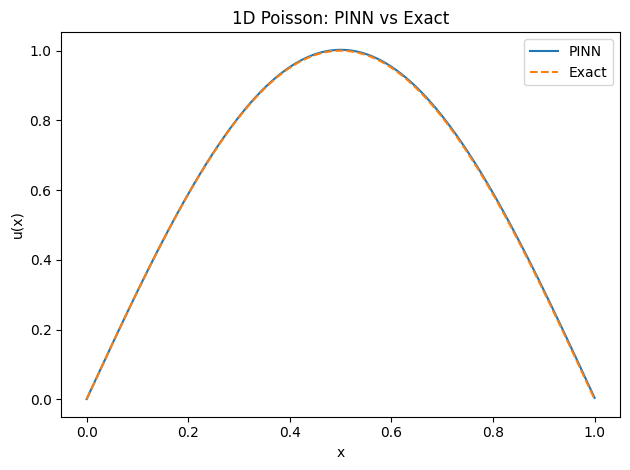

In [1]:
# pip install torch numpy matplotlib
import torch, numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 1) Problem setup
# ----------------------------
pi = np.pi

def f_true(x):  # forcing term f(x) = π^2 sin(πx)
    return (pi**2)*torch.sin(pi*x)

def u_exact(x):  # exact solution for comparison
    return torch.sin(pi*x)

# ----------------------------
# 2) PINN model
# ----------------------------
class MLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)

# ----------------------------
# 3) Collocation (physics) + BC points
# ----------------------------
N_f = 2000   # interior collocation points
N_b = 2      # boundary points at x=0 and x=1

# interior points in (0,1)
x_f = torch.rand((N_f,1), device=device, dtype=torch.float32)
x_f.requires_grad_(True)  # we need grads wrt x for AD

# boundary points (0 and 1)
x_b = torch.tensor([[0.0],[1.0]], device=device, dtype=torch.float32)
u_b = torch.zeros_like(x_b)  # u(0)=0, u(1)=0

# ----------------------------
# 4) Loss pieces (AD for derivatives)
# ----------------------------
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def pde_residual(x):
    """R(x) = -u''(x) - f(x). Uses AD twice for u_x and u_xx."""
    u = model(x)
    # first derivative
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                retain_graph=True, create_graph=True)[0]
    # second derivative
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx),
                                  retain_graph=True, create_graph=True)[0]
    R = -d2u_dx2 - f_true(x)
    return R

# ----------------------------
# 5) Training loop
# ----------------------------
epochs = 5000
lambda_bc = 10.0  # strengthen BC a bit
for ep in range(1, epochs+1):
    optimizer.zero_grad()

    # physics loss (interior)
    R = pde_residual(x_f)
    loss_pde = mse(R, torch.zeros_like(R))

    # boundary loss
    u_hat_b = model(x_b)
    loss_bc = mse(u_hat_b, u_b)

    loss = loss_pde + lambda_bc*loss_bc
    loss.backward()
    optimizer.step()

    if ep % 500 == 0:
        print(f"Epoch {ep:5d} | Loss: {loss.item():.6e} | PDE: {loss_pde.item():.3e} | BC: {loss_bc.item():.3e}")

# ----------------------------
# 6) Evaluation & plot
# ----------------------------
with torch.no_grad():
    x_plot = torch.linspace(0,1,401, device=device).view(-1,1)
    u_pred = model(x_plot)
    u_ref  = u_exact(x_plot)
    rel_l2 = torch.linalg.norm(u_pred - u_ref) / torch.linalg.norm(u_ref)
    print(f"Relative L2 error: {rel_l2.item():.3e}")

x_cpu = x_plot.cpu().numpy().ravel()
plt.figure()
plt.plot(x_cpu, u_pred.cpu().numpy(), label="PINN")
plt.plot(x_cpu, u_ref.cpu().numpy(), '--', label="Exact")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.title("1D Poisson: PINN vs Exact")
plt.legend(); plt.tight_layout()
plt.show()
